In [1]:
# This program uses XGBoost with Stroke data from Kaggle
# Source: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve,\
                            precision_recall_curve, f1_score, auc, precision_score, recall_score

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter 

In [3]:
class imbal_XGB(object):
    
    """
    A class to process data from Kaggle and to predict, whether Strokes in patients may occur or not,
    depending on diffierent idicators, used as features and then as predictors. It is an unbalanced
    data set, hence two different approaches are available: one with weight coefficients and the 
    other one includes data replication only for the positive class. XGBoost will be used as the
    deafault algorithm for binary classification.
    
    ...

    Attributes
    ----------
    path_to_data: str
        String to indicate the path to the data. Example: 'your_path/your_data.csv'
    
    Methods
    -------
    load_data(path_to_data):
        Loads the data and prints its info.
    filter_data():
        Performs custom filtering, by filling NaNs with 0 and converting all non-numeric
        colums to numeric. Also replacing string values with integers. In the end
        descriptive statistics is available too for each feature including the target.
    balance_check():
        Returns the number of positive and negative target instances.
    split_train_predict(weight_coeff):
        Performs initialization of XGBoost, depending on the bool weight_coeff, which
        deafault is True. If true, weight coefficients will be used for each class. If 
        False, instead data will be synthetically generated via SMOTE method (a.k.a.:
        Syntehtic Minority Over-sampling Technique). After the choice of weight_coeff,
        random split is performed, then fit() and predict() methods are called.
    eval_model():
        Evaluates the model performance with y_train. Confusion matrix, Precision-Recall,
        ROC curves and the summary matrix are computed as evaluation metrics. 
        
    """
    
    
    __slots__ = ['df_raw','df','model_xgb','summary', 'sm',
                 'target','X_train','X_test','y_train','y_test',
                 'y_pred','accuracy','precision','recall','thresholds','auc','f1','cm']
    
    def __init__(self, path_to_data:str) -> None:
        
        #Sanity check(s):
        if path_to_data is None:
            raise TypeError('Invalid None type of <<path_to_data>>. Only string values are accepted.')

        if type(path_to_data) is not str:
            raise TypeError('Invalid type of <<path_to_data>>. Only string values are accepted.')
            
        print('\nWroking dir set to:', path_to_data)
        
    def load_data(self, path_to_data:str) -> None: 
        
        self.df_raw = pd.read_csv(path_to_data, index_col = False)
        print('\nData successfully loaded.\n')
        print('\nData shape:', self.df_raw.shape)
        print('\n\nData head:\n\n', self.df_raw.head())
        
    def filter_data(self): 

        print('\nDropping id column ... \n')
        self.df = self.df_raw.drop(['id'], axis = 1)
        
        print('\nNumeric conversions on columns and NaNs fill with 0 ... \n')
        self.df['gender'] = self.df['gender'].replace(['Male', 'Female', 'Other'], ['1', '0', '-1']).astype(int)
        self.df['ever_married'] = self.df['ever_married'].replace(['Yes', 'No'], ['1', '0']).astype(int)
        self.df['work_type'] = self.df['work_type'].replace(['children', 'Govt_job', 'Never_worked', 'Private', 'Self-employed'],
                                                            ['0', '1', '-1', '2', '3']).astype(int)
        self.df['Residence_type'] = self.df['Residence_type'].replace(['Urban', 'Rural'], ['1', '0']).astype(int)
        self.df['smoking_status'] = self.df['smoking_status'].replace(['formerly smoked', 'never smoked', 'Unknown', 'smokes'],
                                                                      ['1', '0', '-1', '2']).astype(int)
        self.df.fillna(0, inplace = True)
        print('\nData shape:', self.df.shape)
        print('\n\nData head:\n\n', self.df.head())
        print('\n\nDescriptive statistics:\n\n', self.df.describe())
        
    def balance_check(self):
        
        print('\nNumber of positive cases in stroke:', len(self.df[self.df['stroke'] == 1]))
        print('\nNumber of negative cases in stroke:', len(self.df[self.df['stroke'] != 1]))
  
    def split_train_predict(self, weight_coeff = True):
        
        
        if weight_coeff == True:
            self.model_xgb = XGBClassifier(booster = 'gbtree', gamma = 0.01, alpha = 0.01, 
                                           eval_metric = 'error', n_estimators = 99, random_state = 12, 
                                           scale_pos_weight = len(self.df[self.df['stroke'] != 1])/len(self.df[self.df['stroke'] == 1]),
                                           learning_rate = 0.6, n_jobs = -1) 
            
        else:
            self.sm = SMOTE(sampling_strategy = 'minority', random_state = 42, n_jobs = -1)
            X_res, y_res = self.sm.fit_resample(self.df.iloc[:,:-1], self.df['stroke'])
            print('\nOld data shape:\n', self.df.shape)
            cols = self.df.columns
            self.df = pd.concat([X_res, y_res], axis = 1, ignore_index = True)
            self.df = self.df.fillna(0)
            self.df.columns = cols
            
            print('\nNew data shape:\n', self.df.shape)
            print('\nResampled target classes:\n', Counter(y_res))
            
            del X_res, y_res, cols
            
            self.model_xgb = XGBClassifier(booster = 'gbtree', gamma = 0.01, alpha = 0.01, 
                                           eval_metric = 'error', n_estimators = 99, random_state = 12, 
                                           learning_rate = 0.6, n_jobs = -1)
            
            
        self.target = self.df['stroke'].astype('category')
    
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.df.iloc[:,:-1], 
                                                                                self.target, 
                                                                                train_size = 0.9,
                                                                                test_size =  0.1,
                                                                                random_state = 12)

        print('\nTrain data size:\n', self.X_train.shape)
        print('\nTеst data size:\n', self.X_test.shape)
        print('\nTrain label size:\n', self.y_train.shape)
        print('\nTest label size:\n', self.y_test.shape)
            
            
        self.model_xgb.fit(self.X_train, self.y_train)

        print(self.model_xgb)   

        self.y_pred = self.model_xgb.predict_proba(self.X_test)
        self.accuracy = accuracy_score(self.y_test, np.round(self.y_pred[:,1]))
        print("Accuracy: %.2f%%" % (self.accuracy * 100.0))
     
  
    def eval_model(self):
        
        self.summary = classification_report(self.y_test, np.round(self.y_pred[:,1]))
        print('\nPrecision, recall, accuracy and f1-score:\n', self.summary)
        
        self.precision, self.recall, self.thresholds = precision_recall_curve(self.y_test, np.round(self.y_pred[:,1]))
        
        plt.figure()
        plt.plot(self.recall, self.precision)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision - Recall Curve')
        plt.show()
        
        self.f1, self.auc = f1_score(self.y_test, np.round(self.y_pred[:,1])), auc(self.recall, self.precision)
        print('\nAUC:', f'{self.auc:.2}')
        
        self.cm = confusion_matrix(self.y_test, np.round(self.y_pred[:,1]))
        print('\nThe confusion matrix:\n', self.cm)

In [4]:
path = 'healthcare-dataset-stroke-data.csv'

In [5]:
gb = imbal_XGB(path)


Wroking dir set to: healthcare-dataset-stroke-data.csv


In [6]:
gb.load_data(path)


Data successfully loaded.


Data shape: (5110, 12)


Data head:

       id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4

In [7]:
gb.filter_data()


Dropping id column ... 


Numeric conversions on columns and NaNs fill with 0 ... 


Data shape: (5110, 11)


Data head:

    gender   age  hypertension  heart_disease  ever_married  work_type  \
0       1  67.0             0              1             1          2   
1       0  61.0             0              0             1          3   
2       1  80.0             0              1             1          2   
3       0  49.0             0              0             1          2   
4       0  79.0             1              0             1          3   

   Residence_type  avg_glucose_level   bmi  smoking_status  stroke  
0               1             228.69  36.6               1       1  
1               0             202.21   0.0               0       1  
2               0             105.92  32.5               0       1  
3               1             171.23  34.4               2       1  
4               0             174.12  24.0               0       1  


Descriptive statistic

In [8]:
gb.balance_check()


Number of positive cases in stroke: 249

Number of negative cases in stroke: 4861


In [9]:
gb.split_train_predict(weight_coeff = True)


Train data size:
 (4599, 10)

Tеst data size:
 (511, 10)

Train label size:
 (4599,)

Test label size:
 (511,)
XGBClassifier(alpha=0.01, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=0.01, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.6, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=99, n_jobs=-1, num_parallel_tree=None,
              predictor=None, ...)
Accuracy: 91.78%



Precision, recall, accuracy and f1-score:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       482
           1       0.19      0.14      0.16        29

    accuracy                           0.92       511
   macro avg       0.57      0.55      0.56       511
weighted avg       0.91      0.92      0.91       511



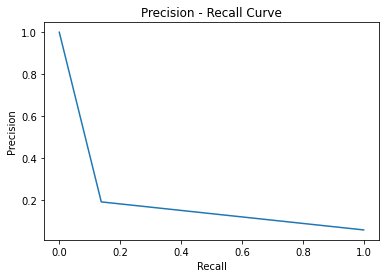


AUC: 0.19

The confusion matrix:
 [[465  17]
 [ 25   4]]


In [10]:
gb.eval_model()

In [11]:
gb.split_train_predict(weight_coeff = False)


Old data shape:
 (5110, 11)

New data shape:
 (9722, 11)

Resampled target classes:
 Counter({1: 4861, 0: 4861})

Train data size:
 (8749, 10)

Tеst data size:
 (973, 10)

Train label size:
 (8749,)

Test label size:
 (973,)


/Users/ddi/python_venv/cnn/cnn/cnn-venv/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


XGBClassifier(alpha=0.01, base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=0.01, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.6, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=99, n_jobs=-1, num_parallel_tree=None,
              predictor=None, ...)
Accuracy: 95.99%



Precision, recall, accuracy and f1-score:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96       488
           1       0.95      0.97      0.96       485

    accuracy                           0.96       973
   macro avg       0.96      0.96      0.96       973
weighted avg       0.96      0.96      0.96       973



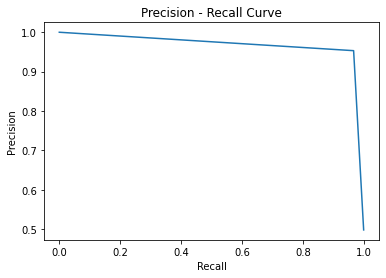


AUC: 0.97

The confusion matrix:
 [[465  23]
 [ 16 469]]


In [12]:
gb.eval_model()